In [21]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import QuantileTransformer, StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# **Data** **Loading**

In [22]:
# Display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

In [23]:
# Load datasets
traffic_df = pd.read_csv('/content/Traffic.csv')
traffic_two_month_df = pd.read_csv('/content/TrafficTwoMonth.csv')


In [24]:
traffic_df.head(3)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low


In [25]:
traffic_df.head(3)

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low


In [26]:
# Combine datasets
traffic_df['Source'] = 'OneMonth'
traffic_two_month_df['Source'] = 'TwoMonth'
combined_df = pd.concat([traffic_df, traffic_two_month_df], ignore_index=True)

In [27]:
combined_df.head()

,Time,Date,Day of the week,CarCount,BikeCount,BusCount,TruckCount,Total,Traffic Situation,Source
0,12:00:00 AM,10,Tuesday,31,0,4,4,39,low,OneMonth
1,12:15:00 AM,10,Tuesday,49,0,3,3,55,low,OneMonth
2,12:30:00 AM,10,Tuesday,46,0,3,6,55,low,OneMonth
3,12:45:00 AM,10,Tuesday,51,0,2,5,58,low,OneMonth
4,1:00:00 AM,10,Tuesday,57,6,15,16,94,normal,OneMonth


In [28]:
combined_df.shape

(8928, 10)

# **Exploratory Data Analysis (EDA)**

In [29]:
#Distribution of vehicle counts for cars, bikes, buses, and trucks
fig = make_subplots(rows=2, cols=2, subplot_titles=("Car Counts", "Bike Counts", "Bus Counts", "Truck Counts"))

fig.add_trace(go.Histogram(x=combined_df['CarCount'], name='Car Counts', marker_color='#1f77b4'), row=1, col=1)
fig.add_trace(go.Histogram(x=combined_df['BikeCount'], name='Bike Counts', marker_color='#ff7f0e'), row=1, col=2)
fig.add_trace(go.Histogram(x=combined_df['BusCount'], name='Bus Counts', marker_color='#2ca02c'), row=2, col=1)
fig.add_trace(go.Histogram(x=combined_df['TruckCount'], name='Truck Counts', marker_color='#d62728'), row=2, col=2)

fig.update_layout(title_text='Distribution of Vehicle Counts', title_x=0.5, showlegend=False, template='plotly_white')
fig.update_xaxes(title_text="Count")
fig.update_yaxes(title_text="Frequency")
fig.show()

In [30]:
# Distribution of traffic situations
fig = px.pie(combined_df, names='Traffic Situation', title='Traffic Situation Distribution', color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_layout(title_text='Traffic Situation Distribution', title_x=0.5, template='plotly_white')
fig.show()

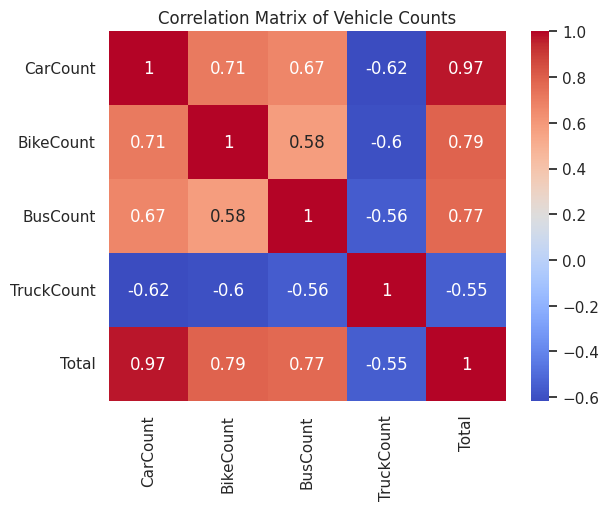

In [31]:
#Correlations between different vehicle types
corr_matrix = combined_df[['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Vehicle Counts')
plt.show()

# **Data Preprocessing**

In [32]:
# Remove outliers using IQR method
def remove_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df
vehicle_cols = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']
combined_df = remove_outliers(combined_df, vehicle_cols)

In [33]:
 #Check for missing values and duplicates
print("Missing values in each column:")
print(combined_df.isnull().sum())

print(f"Number of duplicate rows: {combined_df.duplicated().sum()}")

Missing values in each column:
Time                 0
Date                 0
Day of the week      0
CarCount             0
BikeCount            0
BusCount             0
TruckCount           0
Total                0
Traffic Situation    0
Source               0
dtype: int64
Number of duplicate rows: 0


In [34]:
# Normalize vehicle count columns
scaler = QuantileTransformer(output_distribution='normal')
combined_df[vehicle_cols] = scaler.fit_transform(combined_df[vehicle_cols])

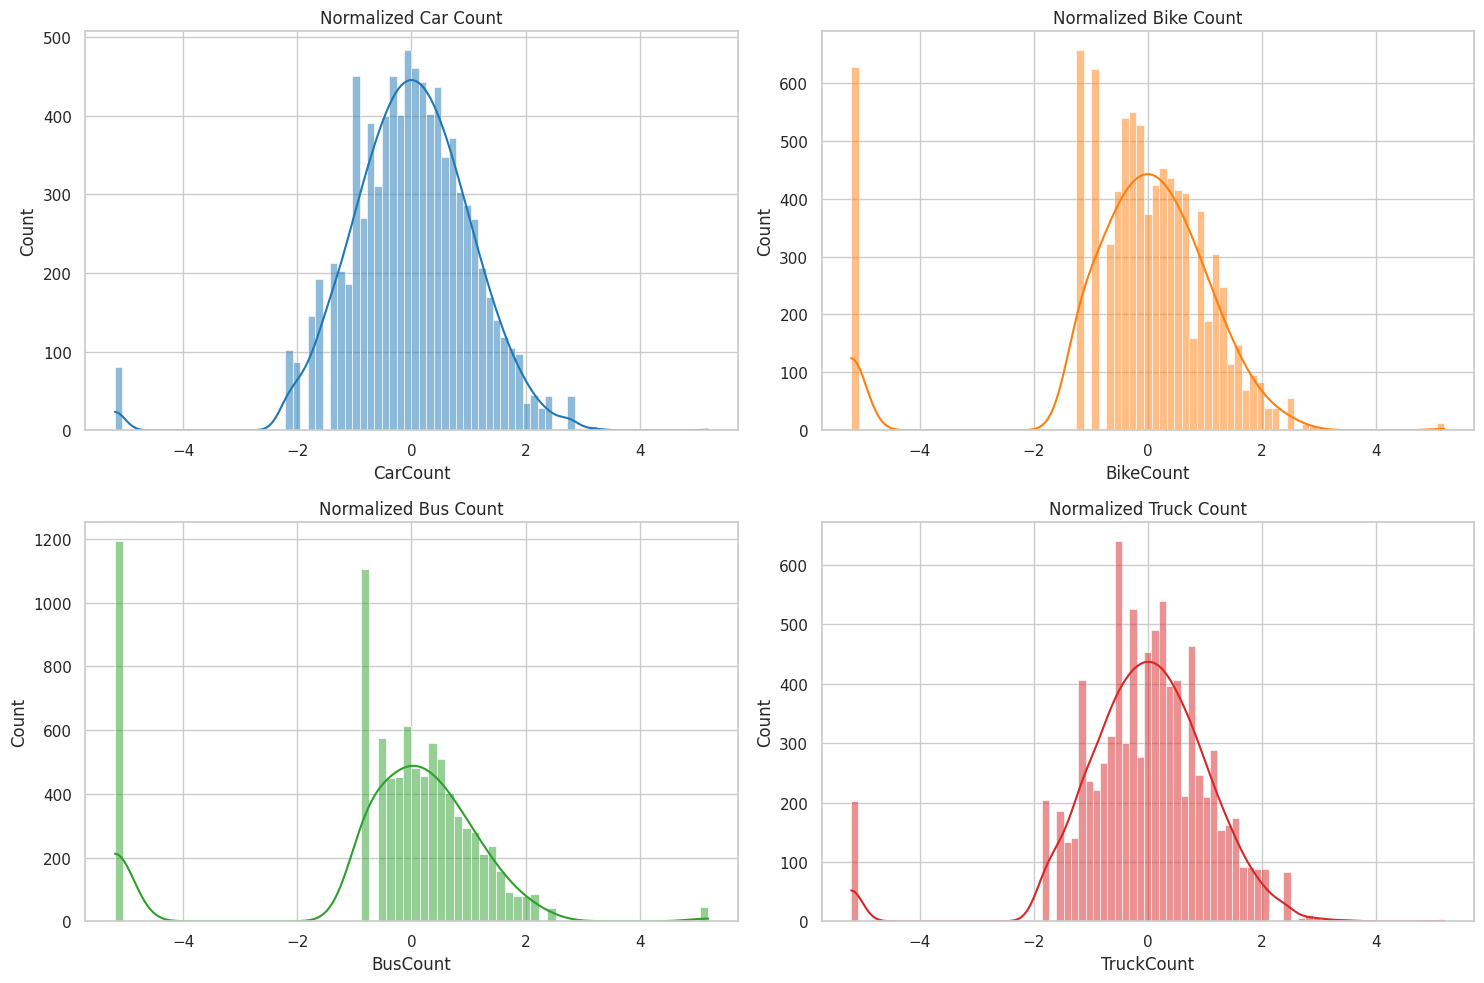

In [35]:
# Check distribution after normalization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(combined_df['CarCount'], ax=axes[0, 0], kde=True, color='#1f77b4')
sns.histplot(combined_df['BikeCount'], ax=axes[0, 1], kde=True, color='#ff7f0e')
sns.histplot(combined_df['BusCount'], ax=axes[1, 0], kde=True, color='#2ca02c')
sns.histplot(combined_df['TruckCount'], ax=axes[1, 1], kde=True, color='#d62728')
axes[0, 0].set_title('Normalized Car Count')
axes[0, 1].set_title('Normalized Bike Count')
axes[1, 0].set_title('Normalized Bus Count')
axes[1, 1].set_title('Normalized Truck Count')
plt.tight_layout()
plt.show()

In [36]:
# Feature engineering
combined_df['Hour'] = pd.to_datetime(combined_df['Time'], errors='coerce').dt.hour
combined_df['Day'] = pd.to_datetime(combined_df['Date'], errors='coerce').dt.day
combined_df['Month'] = pd.to_datetime(combined_df['Date'], errors='coerce').dt.month
combined_df['Weekend'] = combined_df['Day of the week'].isin(['Friday', 'Saturday']).astype(int)

<ipython-input-36-115961a1dd3a>:2: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [37]:
# Features
numeric_features = ['CarCount', 'BikeCount', 'BusCount', 'TruckCount', 'Total', 'Hour', 'Day', 'Month']
categorical_features = ['Day of the week', 'Source']


In [38]:
# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [39]:
# Target encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(combined_df['Traffic Situation'])
X = combined_df[numeric_features + categorical_features]

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Random Forest**

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score


# Build the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__bootstrap': [True, False]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)
y_proba_all = best_model.predict_proba(X_test)

# Evaluation metrics
print("Best Parameters:")
print(grid_search.best_params_)

print("\n Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:
{'classifier__bootstrap': False, 'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

 Classification Report:
              precision    recall  f1-score   support

       heavy       1.00      1.00      1.00       333
        high       0.98      1.00      0.99       122
         low       1.00      0.99      0.99       238
      normal       1.00      1.00      1.00      1051

    accuracy                           1.00      1744
   macro avg       0.99      1.00      1.00      1744
weighted avg       1.00      1.00      1.00      1744



In [42]:
# Calculating weighted averages
accuracy = accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\n Weighted Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision (Weighted)    : {precision_weighted:.4f}")
print(f"Recall (Weighted)       : {recall_weighted:.4f}")
print(f"F1-score (Weighted)     : {f1_weighted:.4f}")

# Multi-class AUC-ROC using One-vs-Rest (OvR)
n_classes = len(label_encoder.classes_)
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Handle binary and multi-class AUC-ROC
y_score = best_model.predict_proba(X_test)

auc_roc = roc_auc_score(y_test_bin, y_score, average='weighted', multi_class='ovr')
print("AUC-ROC Score:", auc_roc)


 Weighted Evaluation Metrics:
Accuracy : 0.9966
Precision (Weighted)    : 0.9966
Recall (Weighted)       : 0.9966
F1-score (Weighted)     : 0.9966
AUC-ROC Score: 0.9997485966423452



 Confusion Matrix:


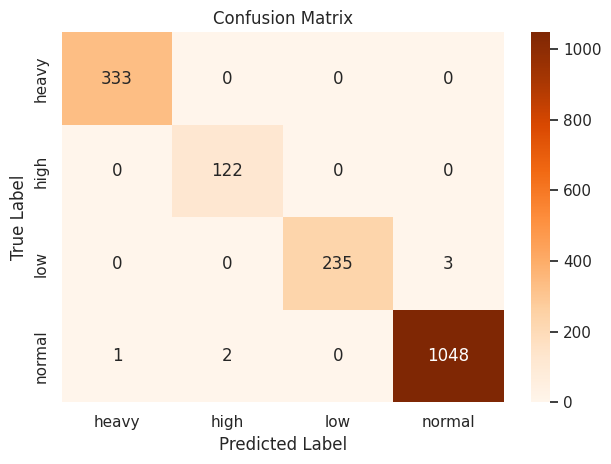

In [43]:
# Confusion Matrix
print("\n Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()